# Groups

In [64]:
import numpy as np

model_name = "pythia_410m"
n_tokens = 10_000_000
method = "angular"
n_tokens_label = f"{float(n_tokens) / 1e6:.1f}M"

all_dist = np.load(f"../dist/{model_name}_{n_tokens_label}_{method}.npy")
dist = np.nanmean(all_dist, 0)
nl = dist.shape[0]
all_dist.shape

(9785, 24, 24)

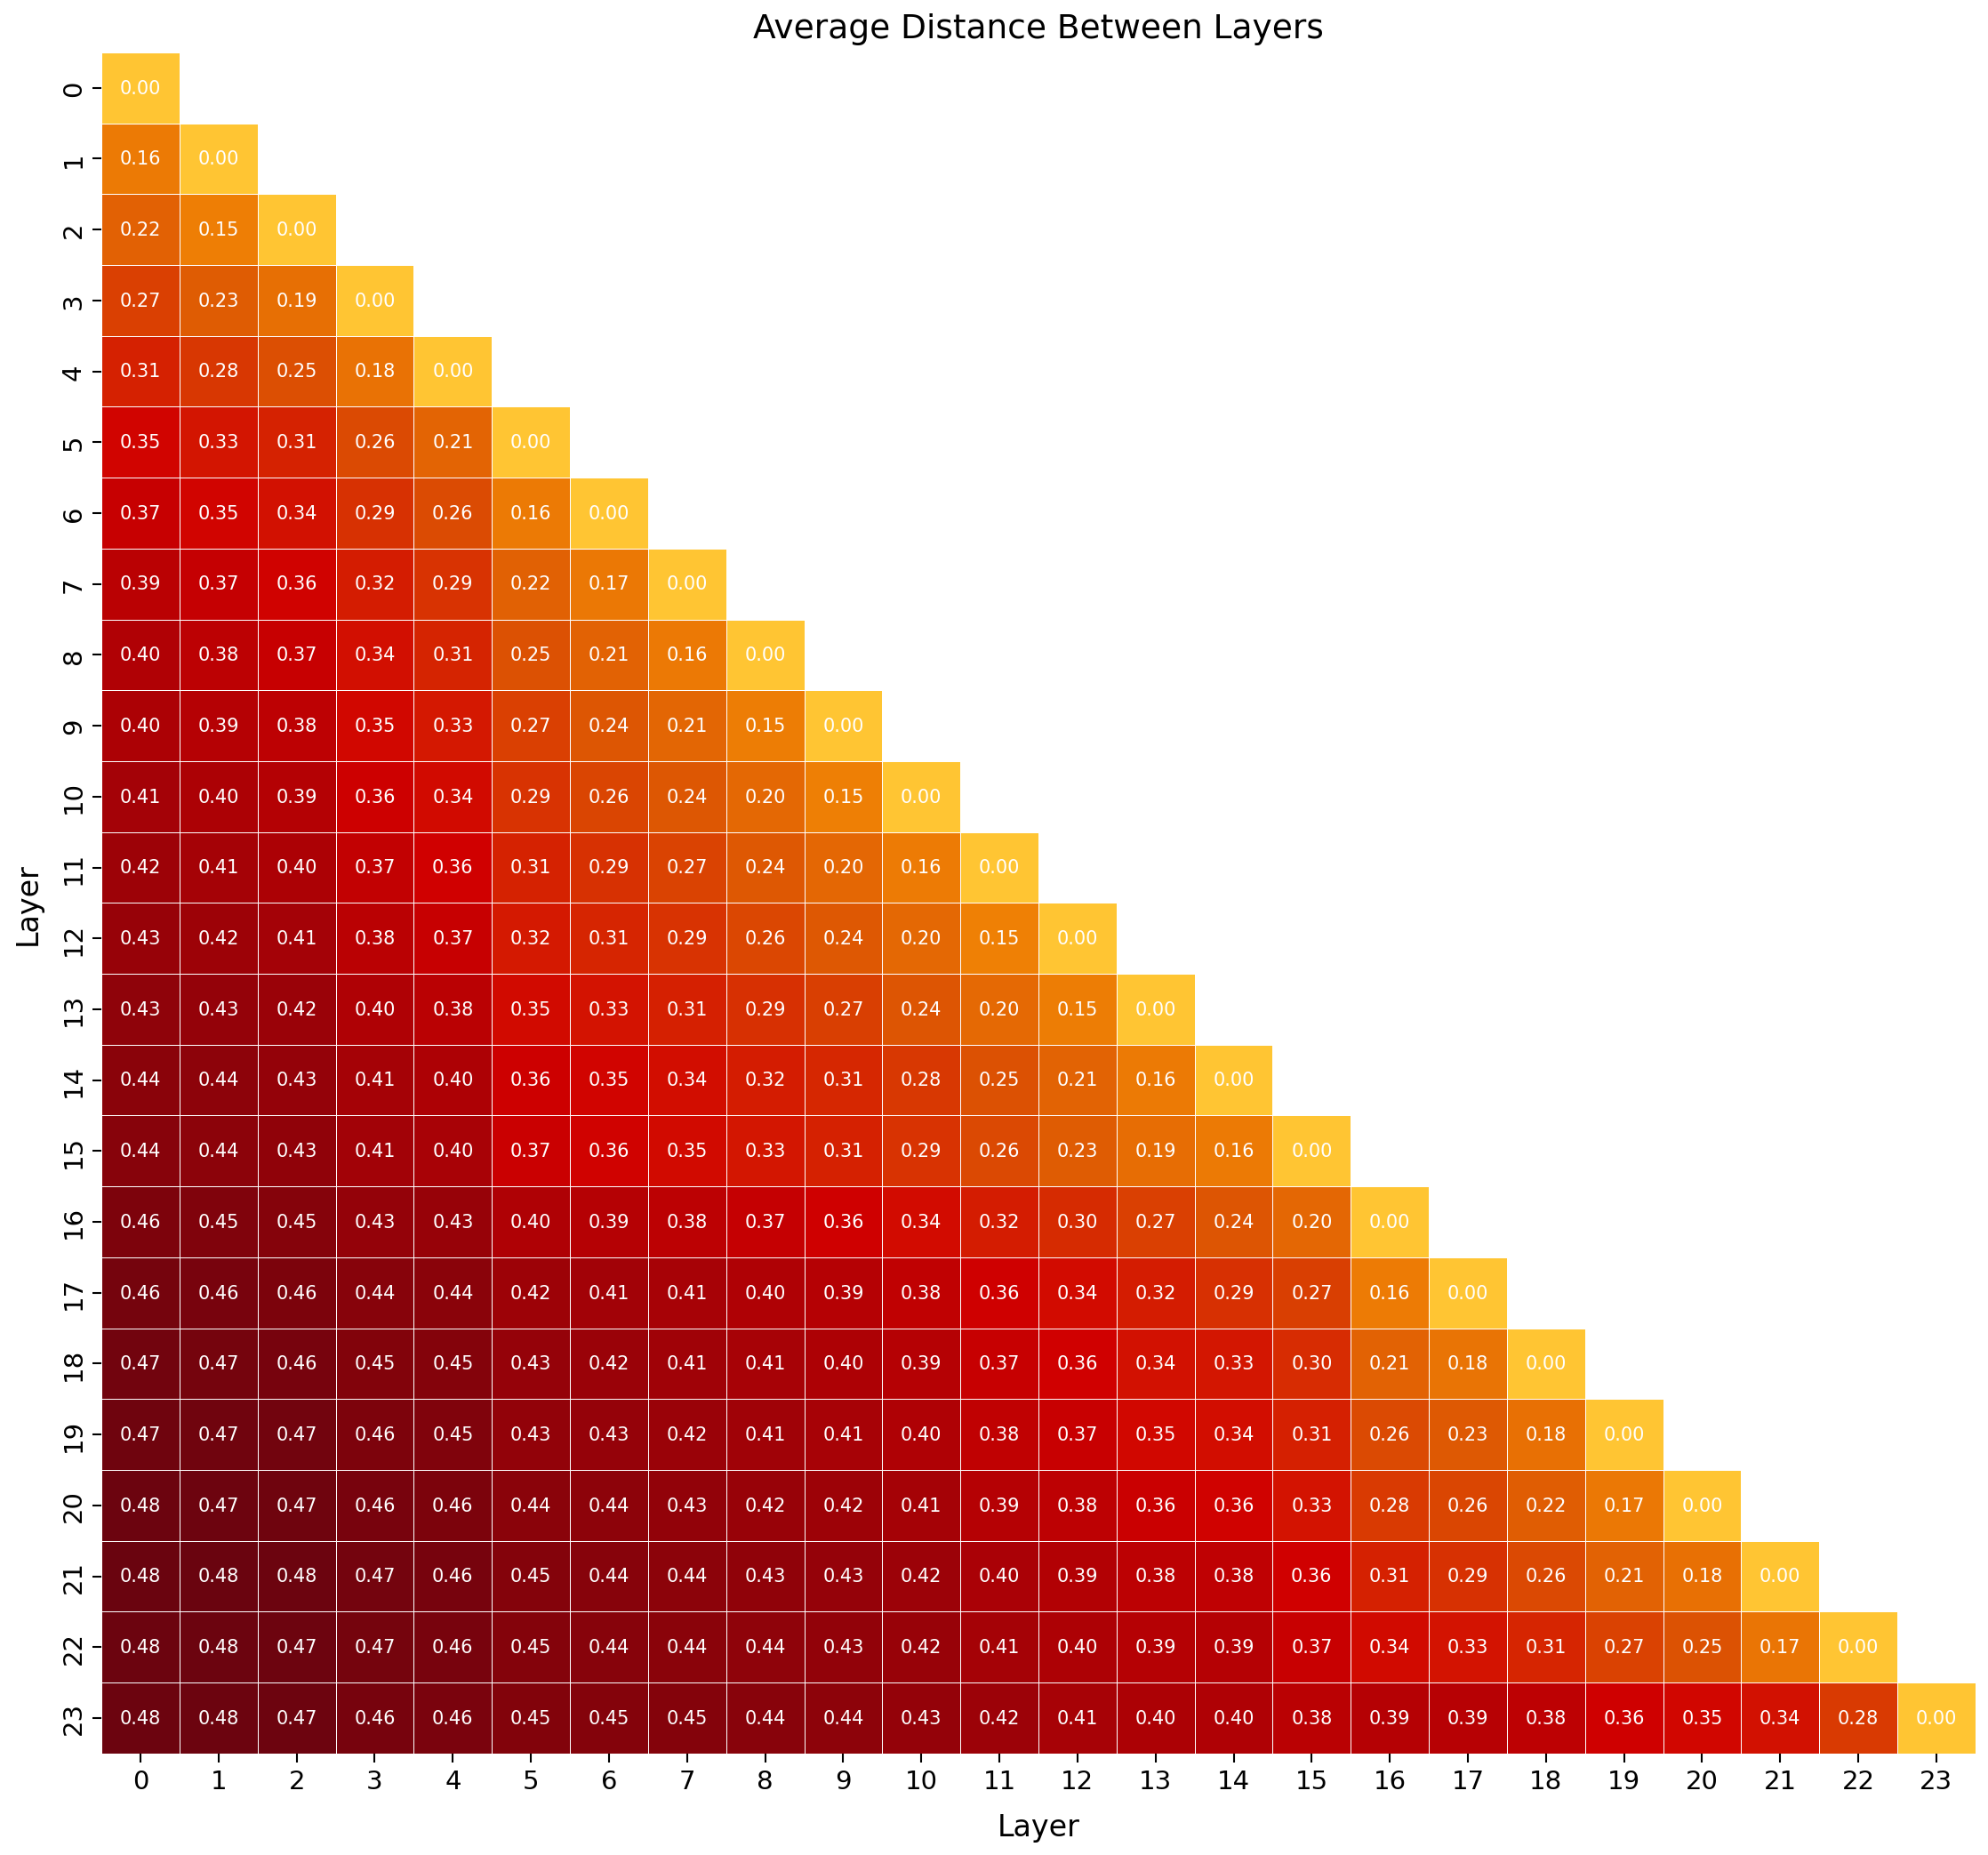

In [65]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

from group_sae.utils import cmap

os.makedirs("img", exist_ok=True)

sns.set_context("paper")
scale = nl / 25
fig, ax = plt.subplots(1, 1, figsize=(int(16 * scale), int(15 * scale)), dpi=150, layout="tight")  # 12, 11

cmap.set_bad("white")
dist_bad = np.copy(dist)
dist_bad[np.triu_indices_from(dist_bad, 1)] = np.nan
mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)

sns.heatmap(
    dist_bad,
    cmap=cmap,
    vmin=0,
    annot=True,
    fmt=".2f",
    ax=ax,
    mask=np.triu(dist),
    square=False,
    linewidths=0.3,
    linecolor="white",
    cbar=False,
    annot_kws={"size": 10, "color": "white"},
)

ax.set_title("Average Distance Between Layers", pad=8, fontsize=18)
# ax.set_ylim(0, 1)

ax.set_xlabel("Layer", labelpad=10, fontsize=16)
ax.set_ylabel("Layer", labelpad=10, fontsize=16)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.savefig(f"img/{model_name}_{n_tokens}.pdf", dpi=300, bbox_inches="tight")

In [68]:
import json

from sklearn.cluster import AgglomerativeClustering

scores = []
num_batches = 2000

for i in range(all_dist.shape[0] // num_batches + 1):
    print(f"Batch {i + 1}/{all_dist.shape[0] // num_batches + 1}")
    dist_sub = all_dist[: (i + 1) * num_batches].mean(0)
    X = np.array(dist_sub) #[:-1, :-1])
    X[np.isinf(X)] = 0
    X[np.isnan(X)] = 0
    X = np.nan_to_num(X)

    clusters = {}

    for k in range(1, nl // 2 + 1):
        clustering = AgglomerativeClustering(
            n_clusters=k, linkage="complete", compute_distances=True
        ).fit(X)

        cluster_dist = [X[clustering.labels_ == i][:, clustering.labels_ == i].max() for i in range(k)]
        print(f"K{k}:\t", clustering.labels_, "AMD:", np.round(max(cluster_dist), 3))

        clusters[k] = {
            "labels": [str(i) for i in clustering.labels_],
            "maad": float(np.round(max(cluster_dist), 3))
        }

with open(f"maad/{model_name}.json", "w") as f:
    json.dump(clusters, f)

Batch 1/5
K1:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] AMD: 0.479
K2:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1] AMD: 0.479
K3:	 [2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1] AMD: 0.447
K4:	 [2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 3 3] AMD: 0.396
K5:	 [2 2 2 2 2 4 4 4 4 4 4 4 1 4 1 1 1 0 0 0 0 0 3 3] AMD: 0.313
K6:	 [0 0 0 0 0 4 4 4 4 4 4 4 1 4 1 1 1 2 2 2 2 5 3 3] AMD: 0.313
K7:	 [3 3 3 2 2 4 4 4 4 4 4 4 0 4 0 0 0 6 6 6 6 5 1 1] AMD: 0.278
K8:	 [3 3 3 2 2 1 1 1 1 1 1 1 4 1 4 7 7 6 6 6 6 5 0 0] AMD: 0.278
K9:	 [1 1 1 2 2 0 0 0 0 0 0 0 4 0 4 3 3 6 6 6 6 5 8 7] AMD: 0.217
K10:	 [0 0 0 2 2 1 1 1 1 1 4 4 9 4 9 3 3 6 6 6 6 5 8 7] AMD: 0.217
K11:	 [10  2  2  0  0  1  1  1  1  1  4  4  9  4  9  3  3  6  6  6  6  5  8  7] AMD: 0.179
K12:	 [10  2  2 11  9  0  0  0  0  0  1  1  4  1  4  3  3  6  6  6  6  5  8  7] AMD: 0.152
Batch 2/5
K1:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] AMD: 0.479
K2:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1] AMD: 0.479
K3:	 